## overview

In [1]:
# default package
import dataclasses as dc
import logging
import os
import pathlib
import random
import sys
import tempfile
from urllib.request import urlretrieve

import IPython

In [2]:
# third party package
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from tqdm import tqdm

In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(), "../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [6]:
# graph setting
sns.set()
font_path = "/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf"
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams["font.family"] = font_prop.get_name()

## サンプリング
下記の混合正規分布に従う変数を発生させる。
$$
\frac{1}{8}N(-5,1)+
\frac{3}{4}N(0,1)+
\frac{1}{8}N(5,1)
$$

In [7]:
params = pd.DataFrame(
    {"ave": [-5, 0, 5], "scale": [1, 1, 1], "ratio": [1 / 8, 3 / 4, 1 / 8]}
)

In [8]:
def mixture_pdf(params: pd.DataFrame, x: float):
    pdf = 0
    for para in params.iterrows():
        para_ser = para[1]
        pdf += norm.pdf(x, loc=para_ser.ave, scale=para_ser.scale) * para_ser.ratio
    return pdf

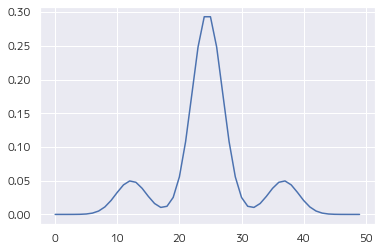

In [9]:
x = np.linspace(-10, 10)
plt.plot(mixture_pdf(params, x))

### numpy

In [10]:
def generate_data(params: pd.DataFrame, n: int = 1000) -> np.ndarray:
    x = np.array([])
    for para in params.iterrows():
        para_ser = para[1]
        x = np.append(
            x,
            np.random.normal(
                loc=para_ser.ave, scale=para_ser.scale, size=int(n * para_ser.ratio)
            ),
        )
    return x

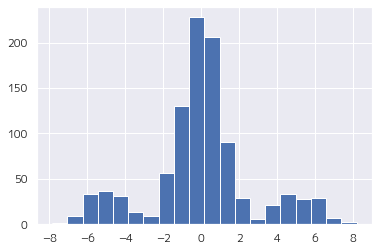

In [11]:
x = generate_data(params)
plt.hist(x, bins=20);

### MH algorithm
提案分布からのサンプリング時にrandom walkを使って、変数を発生させる。
$$
y=\theta^t+u
$$
ここで、$u\sim Uni(0,1)$とする。
このとき、採択確率$\alpha$は、
$$
\alpha=min\{1,\frac{\pi (y)}{\pi (x^t)}\}
$$
となる。ここで、$\pi$は目標分布である。

In [12]:
def mh(a: float, params: pd.DataFrame, num: int = 11000):
    x = 0
    y_series = np.empty(num)
    for i in tqdm(range(num)):
        epsilon = np.random.rand() * 2 * a - a
        u = np.random.rand()
        y = x + epsilon
        adop_rate = min(1, mixture_pdf(params, y) / mixture_pdf(params, x))
        y_series[i] = y if u < adop_rate else x
        x = y_series[i]
    return y_series

In [13]:
y_series = mh(a=1, params=params)

100%|██████████| 11000/11000 [00:14<00:00, 734.63it/s]


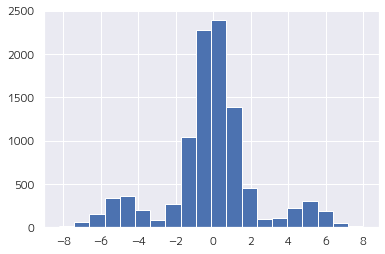

In [14]:
plt.hist(y_series[1000:], bins=20);

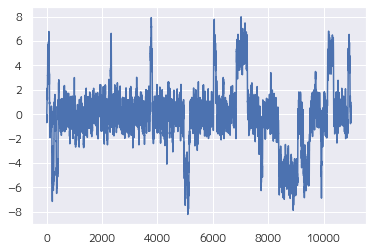

In [15]:
plt.plot(y_series);